# Sparse Identification of nonlinear dynamical systems

One main challenges in science is to identify the governing mechanism based on data. If we are able to learn the underlying dynamics from the available data, then perhaps we have advanced our understanding of our world.

The work from [1], [2] and [3] have shown that we can combine sparsity-promoting techniques and machine learning to find the underlying equations of data.

Interested reader can refer to [1] for details. Briefly, the idea is that we would like to find the **coefficient** of different *basis*. Consider a simple regression model,

\begin{align}
f(x_1, x_2, \cdots x_i) = a_1 x_1 + a_2 x_2 + \cdots + a_i x_i\,.
\end{align}

The goal of regression is to find the coefficient $a_1$ to $a_i$ such that the misfit between the model $f$ and data $y$ is minimised. For example:
$$
\underset{a_1 \cdots a_i}{\text{min}} \quad \left(f(x_1 \cdots x_i) - y \right)^2 + \lambda R\,.
$$
The $x_i$ are the basis for the coefficients $a_i$, and $R$ is the regularisation term. Therefore, if we know what "basis" to be fit, then we can have a robust regression model. The basis do not have to be linear. They can be non-linear functions, e.g. $x_i^2$, $x_i^3$ and $(x_1 x_2 x_3)^{1/2}$, exponential or even harmonics, e.g. $\sin(x_i)$, $\cos(x_i)$ and $\sin{(x_1)}\cos{(x_2)}$ etc.

The idea from [1] is similar. Some parts of the differential equations are known, but we want to find the rest. To put it in context, suppose we know the dynamics of some variables $\mathbf{x}$ that will change with time $t$, but we do not know what is the underlying mechanism that is driving the changes, i.e. the RHS $f(\mathbf{x}, t)$.

\begin{align}
\frac{d \mathbf{x}}{dt} &= f(\mathbf{x}, t)\,.
\end{align}

We hypothesise that the RHS comprises of unknown many basis, e.g.

\begin{align}
\frac{d \mathbf{x}}{dt} &= \underline{a_1} \mathbf{x} + \underline{a_2} \mathbf{x} \cdot \mathbf{x} + \underline{a_3} \mathbf{x} \cdot \mathbf{x} \cdot \mathbf{x} + \cdots\,.
\end{align}

Similarly, we are trying to use optimisation algorithm to find these coefficients.

Below are some examples of how to use Pysindy.


In [1]:
# import required library
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
# pysindy can work with scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# for colab: import pysindy, if import error than install it
try:
  # !pip install git+https://github.com/dynamicslab/pysindy.git
  import pysindy as ps
except ImportError:
  # !pip install pysindy --quiet
  !pip install git+https://github.com/dynamicslab/pysindy.git
  import pysindy as ps

# For presentation remove warning
# In practice, the warning is very useful, so dont remove it!
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# NOTE: some weird dependency clash regarding jaxlib
# NOTE: Dont know how to fix, but the pysindy 'should' still work

### Pysindy 101

A toy example from Pysindy documentation. Suppose we have the following equations,

\begin{align}
\frac{dx}{dt} &= -2x\,, \\
\frac{dy}{dt} &= y\,.
\end{align}

We know the solution to this ODE. But can Pysindy successfully learn the dynamcis?


In [2]:
# test installation / simple example
# the coupled ode:
# dx/dt = -2 x
# dy/dt = y
# make the solution
t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)  # First column is x, second is y

differentiation_method = ps.FiniteDifference(order=2)
# basis
feature_library = ps.PolynomialLibrary(degree=3)
feature_library.fit(X)
print('The basis: ')
print(feature_library.get_feature_names(input_features=['x', 'y']))
print()

# optimiser for regression
optimizer = ps.STLSQ(threshold=0.2)
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"],
)
model.fit(X, t=t)
model.print()

The basis: 
['1', 'x', 'y', 'x^2', 'x y', 'y^2', 'x^3', 'x^2 y', 'x y^2', 'y^3']

(x)' = -2.000 x
(y)' = 1.000 y


### Test case 1: Consecutive reactions (coupled first-order ODE)

Consider a more complicated example. Say we have the following consecutive reactions, e.g. consecutive radioactive decay:

$$
A \xrightarrow{k_1} B \xrightarrow{k_2} C \,,
$$
of which the chemical dynamics can be described by the following coupled ODE:
\begin{align}
\frac{d A}{d t} &= - k_1 A \,,\\
\frac{d B}{d t} &= k_1 A - k_2 B \,,\\
\frac{d C}{d t} &= k_2 B\,.
\end{align}
In the below, $k_1 = 0.05$ and $k_2=0.1$ are chosen.

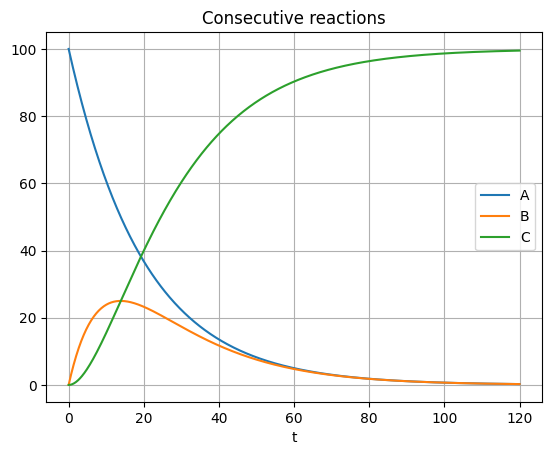

In [3]:
k1 = 0.05
k2 = 0.1

def consecutive_rate_eq(t, abc, k1=k1, k2=k2):
  a, b, c = abc
  return [-k1*a, k1*a - k2*b, k2*b]

t0 = 0
tf = 120
A0, B0, C0 = 100, 0, 0
sol = solve_ivp(consecutive_rate_eq, t_span=[t0, tf], y0=[A0, B0, C0], method='LSODA', dense_output=True)

# plot the output
t = np.linspace(t0, tf, int(tf*6))
z = sol.sol(t)
plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['A', 'B', 'C'])
plt.title('Consecutive reactions')

# # exact solution
# A_exact = A0 * np.exp(-k1*t)
# B_exact = A0 * (k1/(k2-k1))*(np.exp(-k1*t) - np.exp(-k2*t)) + B0 * np.exp(-k2*t)
# C_exact = A0 * (1 + (k1 * np.exp(-k2*t) - k2 * np.exp(-k1*t))/(k2-k1) ) + B0 * (1 - np.exp(-k2*t)) + C0
# plt.plot(t, A_exact)
# plt.plot(t, B_exact)
# plt.plot(t, C_exact)

plt.grid()
plt.show()

In [4]:
X = z.T
feature_names = ['A', 'B', 'C']
differentiation_method = ps.FiniteDifference(order=2)
# basis
feature_library = ps.PolynomialLibrary(degree=3, include_interaction=False)
feature_library.fit(X)
print('The basis: ')
print(feature_library.get_feature_names(input_features=feature_names))
print()
# optimiser for regression
optimizer = ps.STLSQ(threshold=1e-3, normalize_columns=False)
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer ,
    feature_names=feature_names,)
model.fit(X, t=t)
model.print()

The basis: 
['1', 'A', 'B', 'C', 'A^2', 'B^2', 'C^2', 'A^3', 'B^3', 'C^3']

(A)' = -0.050 A
(B)' = 0.050 A + -0.100 B
(C)' = 0.100 B


Pysindy is also compatible with scikit-learn. We can perform cross validation with ``TimeSeriesSplit`` to find the best 'hyperparameters'.

In [5]:
dt = t[1] - t[0]
model = ps.SINDy(t_default=dt, feature_library=feature_library, differentiation_method=differentiation_method,)
param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1, 1.0],
    "optimizer__alpha": [0.01, 0.05, 0.1, 0.15, 0.2],
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(X)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'optimizer__alpha': 0.01, 'optimizer__threshold': 0.001}
(x0)' = -0.050 x0
(x1)' = 0.050 x0 + -0.100 x1
(x2)' = 0.100 x1


### Test case 2: Competitive Lotka-Volterra system (coupled non-linear ODE)

Adding additional term to account for species interactions, the competitive Lotka-Volterra system for two species, $x_1$ and $x_2$, is as follows. (From wiki: [Competitive Lotka-Volterra system](https://en.wikipedia.org/wiki/Competitive_Lotka%E2%80%93Volterra_equations#cite_note-ReferenceA-9) )

\begin{align}
\frac{d x_1}{dt} &= r_1 x_1 \left( 1 - \left(  \frac{x_1 + \alpha_{12}x_2}{K_1}\right)  \right) \,,\\
\frac{d x_2}{dt} &= r_2 x_2 \left( 1 - \left( \frac{x_2 + \alpha_{21} x_1}{K_2} \right) \right) \,.
\end{align}

- $\alpha_{12}$ is the effect of species 2 has on the population of species 1.
- $\alpha_{21}$ is the effect of sepcies 1 has on the population of species 2
- $\alpha$ is positive.
- $r_i$ is the inherent per-capita growth rate
- $K_i$ is the carrying capacity

In [6]:
a12, a21 = 0.63, 0.8
r1, r2 = 0.75, 0.2
K1, K2 = 1, 1
def comp_lotkavolterra(t, z, r1=r1, a12=a12, r2=r2, a21=a21, K1=K1, K2=K2):
  x1, x2 = z
  return [r1 * x1 * (1 - ((x1 + a12 * x2)/K1)), r2 * x2 * (1 - ((x2 + a21*x1)/K2))]

t0, tf = 0, 120
x1_0, x2_0 = 1, 1

sol = solve_ivp(comp_lotkavolterra, [t0, tf], [x1_0, x2_0], method='LSODA', dense_output=True)

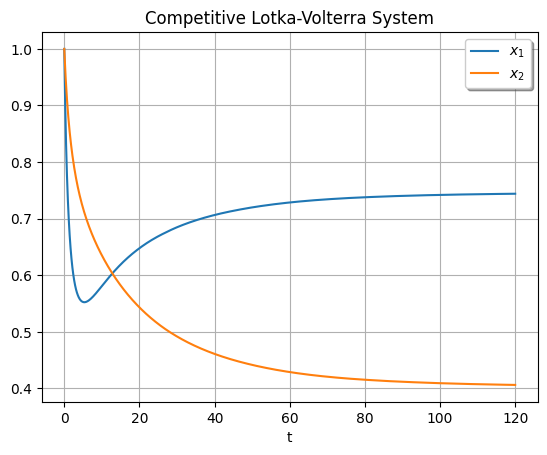

In [7]:
t = np.linspace(t0, tf, 1000)
z = sol.sol(t)
plt.plot(t, z.T)
plt.xlabel('t')
plt.legend([r'$x_1$', r'$x_2$'], shadow=True)
plt.title('Competitive Lotka-Volterra System')
plt.grid(True)
plt.show()

In [8]:
X = z.T
feature_names = ['x1', 'x2']
# differentiation_method = ps.FiniteDifference(order=2)
# basis
feature_library = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=False)
feature_library.fit(X)
print('The basis: ')
print(feature_library.get_feature_names(input_features=feature_names))
print()

print('STLSQ model: ')
# optimiser for regression
optimizer = ps.STLSQ(threshold=0.001, alpha=0.00005, normalize_columns=True)
model = ps.SINDy(
    feature_library=feature_library,
    optimizer=optimizer ,
    feature_names=feature_names,)
model.fit(X, t=t)
model.print()
print('R2 score: ', model.score(X, t=t))

# Other optimiser
print()
print('SR3 model: ')
optimizer = ps.SR3(reg_weight_lam=0.000005, regularizer='l2', normalize_columns=True)
model = ps.SINDy(
    feature_library=feature_library,
    optimizer=optimizer ,
    feature_names=feature_names,)
model.fit(X, t=t)
model.print()
print('R2 score: ', model.score(X, t=t))


# # Code for grid searching
# dt = t[1] - t[0]
# optimizer = ps.STLSQ(normalize_columns=True)
# model = ps.SINDy(t_default=dt, feature_library=feature_library, feature_names=feature_names, optimizer=optimizer)
# param_grid = {
#     "optimizer__threshold": np.arange(1e-9, 1e-7, 1e-8),
#     "optimizer__alpha": np.arange(1e-8, 1e-5, 1e-6),
# }

# search = GridSearchCV(
#     model,
#     param_grid,
#     cv=TimeSeriesSplit(n_splits=2)
# )
# search.fit(X)

# print("Best parameters:", search.best_params_)
# search.best_estimator_.print()

The basis: 
['x1', 'x2', 'x1^2', 'x1 x2', 'x2^2']

STLSQ model: 
(x1)' = 0.621 x1 + 0.112 x2 + -0.621 x1^2 + -0.504 x1 x2 + -0.069 x2^2
(x2)' = -0.027 x1 + 0.224 x2 + 0.028 x1^2 + -0.167 x1 x2 + -0.214 x2^2
R2 score:  0.9998600805546202

SR3 model: 
(x1)' = 0.621 x1 + 0.112 x2 + -0.621 x1^2 + -0.504 x1 x2 + -0.069 x2^2
(x2)' = -0.027 x1 + 0.224 x2 + 0.028 x1^2 + -0.167 x1 x2 + -0.214 x2^2
R2 score:  0.9998600370781865


In [9]:
# print the correct equations
print('The correct equation: ')
print(f"(x1)' = {r1:.3f} x1 - {r1/K1:.3f} x1^2 - {a12 * r1 / K1:.3f} x1 x2")
print(f"(x2)' = {r2:.3f} x2 - {r2/K2:.3f} x2^2 - {a21 * r2 / K2:.3f} x1 x2")
# print('r1: ', r1)
# print('r1/K1: ', r1/K1)
# print('r1 *a12 / K1: ', r1 * a12 / K1)
# print('r2: ', r2)
# print('r2/K2: ', r2/K2)
# print('r2*a21 / K2: ', r2*a21/K2)

The correct equation: 
(x1)' = 0.750 x1 - 0.750 x1^2 - 0.473 x1 x2
(x2)' = 0.200 x2 - 0.200 x2^2 - 0.160 x1 x2


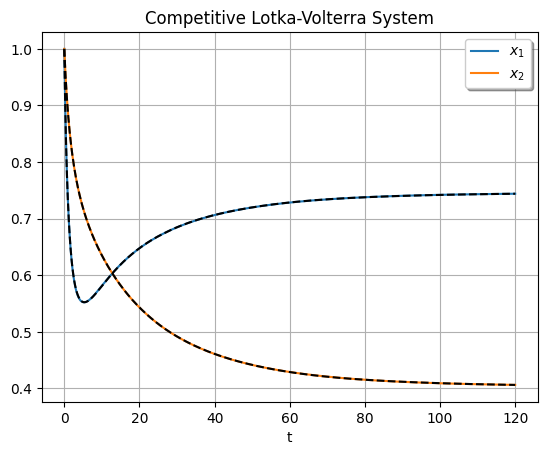

In [10]:
# can the model reproduce the results
sim = model.simulate([x1_0, x2_0], t=t)
plt.plot(t, sim)
plt.plot(t, z.T, 'k--')
plt.xlabel('t')
plt.legend([r'$x_1$', r'$x_2$'], shadow=True)
plt.title('Competitive Lotka-Volterra System')
plt.grid(True)
plt.show()

As you can see, non-linear dynamical system is harder to be predicted / found. The above model suggested equations that "appear" to be correct, but the maths/physics to reproduce it is a bit different.

## Finding PDE

Similar concepts can be applied to finding PDEs, but there are a lot basis to consider, mainly the spatial and temporal derivatives, e.g.,

\begin{align}
\frac{\partial u}{\partial t} &= a_1 \frac{\partial u}{\partial x} + a_2 \frac{\partial u}{\partial y} + a_3 \frac{\partial u}{\partial z} + a_4 \frac{\partial^2 u}{{\partial x}^2} + \cdots
\end{align}

### Test case 3: Stommel ocean gyres model (time-independent second order PDE)

Stommel model for western boundary current (WBC) is an interesting yet simple model that explain the formation of WBC. The rearranged equation, is as follows.

\begin{align}
\nabla^2 \Psi &= - \frac{ a \pi \tau_0}{r L_y} \cos{\left( \pi \left( \frac{a y}{L_y} - \frac{1}{2} \right) \right)} - \frac{\beta}{r} \frac{\partial \Psi}{\partial x} \,\\
&= - \frac{ a \pi \tau_0}{r L_y} \sin{\left(  \frac{\pi a y}{L_y} \right)} - \frac{\beta}{r} \frac{\partial \Psi}{\partial x}\,,
\end{align}

where $r$ is linear friction coefficient, $a$ controls number of gyres, $\tau_0$ is the magnitude of wind stress and $\beta$ is the Coriolis parameter.


Notice this is bit different from previous examples as the LHS is not derivative of time, but space only. In theory and in programming, this should work as well. Below demonstrate this.

Note the exact solution is:

$$
\Psi(x,y)=\frac{\tau_0 L_y}{ar\pi} \left\{ 1- \frac{(1-e^{C_3 L_x}) e^{C_2 x} - (1-e^{C_2 L_x}) e^{C_3 x} }{e^{C_2 L_x} - e^{C_3 L_x}} \right\} \cos{\left( \pi\left( \frac{ay}{L_y} - \frac{1}{2} \right) \right)}
$$

where,

\begin{align}
C_2 &= -\frac{\beta}{2r} + \sqrt{\left( \frac{\beta}{2r} \right)^2 + \left( \frac{a \pi}{L_y} \right)^2}\\
C_3 &= -\frac{\beta}{2r} - \sqrt{\left( \frac{\beta}{2r} \right)^2 + \left( \frac{a \pi}{L_y} \right)^2
}
\end{align}

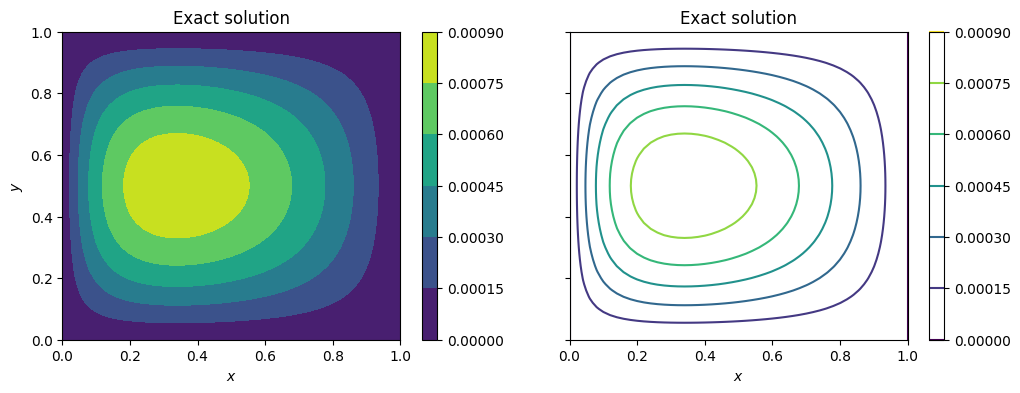

In [11]:
Lx, Ly = 1, 1
nx, ny = 51, 51
r = 0.2
beta = 1.0
tau0 = 0.001
no_gyres = 1

# the exact solution
def psi_exact(
    x,
    y,
    Lx=Lx,         # domain Lx by Ly
    Ly=Ly,
    r=r,          # linear friction coeff
    beta=beta,       # coriolis parameter
    a=no_gyres,            # contol number of gyres, preferably integer
    tau0=tau0):     # magnitude of wind stress

    C2 = -beta / 2 / r + np.sqrt( (beta / 2 / r)**2 + (a*np.pi/Ly)**2 )
    C3 = -beta / 2 / r - np.sqrt( (beta / 2 / r)**2 + (a*np.pi/Ly)**2 )
    A = tau0 * Ly / a / r / np.pi
    nom = (1 - np.exp(C3 * Lx)) * np.exp(C2 * x) - (1 - np.exp(C2 * Lx)) * np.exp(C3 * x)
    denom = np.exp(C2*Lx) - np.exp(C3*Lx)
    wind_harm = np.cos(np.pi*(a*y/Ly - 0.5))

    return A*(1-nom/denom)*wind_harm

x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
dx = x[1] - x[0]
dy = x[1] - x[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# plot exact solution
psi_e = psi_exact(X,Y)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))

cmf = ax[0].contourf(X, Y, psi_e, 5)
cm = ax[1].contour(X, Y, psi_e, 5)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('Exact solution')
fig.colorbar(cmf)

ax[1].set_xlabel(r'$x$')
ax[1].set_title('Exact solution')
fig.colorbar(cm)

In [12]:
# the below code is modified from Pysindy example

psi_xx = ps.FiniteDifference(d=2, axis=0)._differentiate(psi_e, dx)
psi_yy = ps.FiniteDifference(d=2, axis=1)._differentiate(psi_e, dy)

mod_lib_func = [
    lambda x: np.sin(1 * no_gyres * np.pi / Ly * x),
    lambda x: np.cos(1 * no_gyres * np.pi / Ly * x),
    lambda x: np.sin(2 * no_gyres * np.pi / Ly * x),
    lambda x: np.cos(2 * no_gyres * np.pi / Ly * x),
    lambda x: np.sin(3 * no_gyres * np.pi / Ly * x),
    lambda x: np.cos(3 * no_gyres * np.pi / Ly * x),
]
mod_func_name = [
    lambda x: 'sin(1*pi*a*' + x + '/Ly)',
    lambda x: 'cos(1*pi*a*' + x + '/Ly)',
    lambda x: 'sin(2*pi*a*' + x + '/Ly)',
    lambda x: 'cos(2*pi*a*' + x + '/Ly)',
    lambda x: 'sin(3*pi*a*' + x + '/Ly)',
    lambda x: 'cos(3*pi*a*' + x + '/Ly)',
]

# define library
poly_lib = ps.PolynomialLibrary(include_bias=False)
mod_fourier_lib = ps.CustomLibrary(
    library_functions=mod_lib_func,
    function_names=mod_func_name,)
X_mesh, Y_mesh = np.meshgrid(x, y)
pde_library = ps.PDELibrary(
    function_library=ps.CustomLibrary(library_functions=[], function_names=[]),
    derivative_order=1,
    spatial_grid=np.asarray([X_mesh, Y_mesh]).T,
)

# inputa are going to be psi, X, Y
data = np.transpose(np.asarray([psi_e, X, Y]), [1, 2, 0])
# x_dot = lapacian
lap_psi = psi_xx + psi_yy
data_dot = np.transpose(np.asarray([lap_psi, X, Y]), [1, 2, 0])

# Tensor polynomial library with the PDE library
tensor_array = [[1, 0, 1]]
# Remove X and Y from PDE library terms because why would we take these derivatives
# Remove sine and cosine of psi
inputs_per_library = [(0, 1, 2), (1, 2), (0,)]

# Fit a generalized library of 3 feature libraries + 1 internally
# generated tensored library and only use the input variable phi
# for the PDELibrary. Note that this holds true both for the
# individual PDELibrary and any tensored libraries constructed from it.
generalized_library = ps.GeneralizedLibrary(
    [poly_lib, mod_fourier_lib, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)
print('The basis: ')
generalized_library.fit(data)
print(generalized_library.get_feature_names(input_features=['psi', 'x', 'y']))

The basis: 
['psi', 'x', 'y', 'psi^2', 'psi x', 'psi y', 'x^2', 'x y', 'y^2', 'sin(1*pi*a*x/Ly)', 'sin(1*pi*a*y/Ly)', 'cos(1*pi*a*x/Ly)', 'cos(1*pi*a*y/Ly)', 'sin(2*pi*a*x/Ly)', 'sin(2*pi*a*y/Ly)', 'cos(2*pi*a*x/Ly)', 'cos(2*pi*a*y/Ly)', 'sin(3*pi*a*x/Ly)', 'sin(3*pi*a*y/Ly)', 'cos(3*pi*a*x/Ly)', 'cos(3*pi*a*y/Ly)', 'psi_2', 'psi_1', 'psi psi_2', 'psi psi_1', 'x psi_2', 'x psi_1', 'y psi_2', 'y psi_1', 'psi^2 psi_2', 'psi^2 psi_1', 'psi x psi_2', 'psi x psi_1', 'psi y psi_2', 'psi y psi_1', 'x^2 psi_2', 'x^2 psi_1', 'x y psi_2', 'x y psi_1', 'y^2 psi_2', 'y^2 psi_1']


In [13]:
# fit here
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-3, normalize_columns=True)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi', 'x', 'y'])
model.fit(data, x_dot=data_dot)
model.print()

(psi)' = -0.016 sin(1*pi*a*y/Ly) + -4.984 psi_1
(x)' = 1.000 x
(y)' = 1.000 y


In [14]:
# the correct coefficients
print('beta/r: ', beta/r)
print('(a*pi*tau0) / (r*Ly): ', no_gyres * np.pi * tau0/ r/ Ly)

beta/r:  5.0
(a*pi*tau0) / (r*Ly):  0.015707963267948967


### Test case 4: 2D Diffusion equation (time dependent second order PDE)

Below is the 2D diffusion equation with Dirichlet boundary conditions. The initial condition is something like gaussian function (not exactly) in the center of the domain.

\begin{align}
\frac{\partial u}{{\partial t}} &= D \nabla^2 u = D \left( \frac{\partial^2 u}{{\partial x}^2} + \frac{\partial^2 u}{{\partial y}^2}\right) \quad \Omega \in [0, L_x] \times [0, L_y]\,\\
u (x,y,0) &= \frac{1}{2 \pi \sigma_x \sigma_y} e^{- \left(\frac{(x - \mu_x)^2}{(2 \sigma_x^2)} + \frac{(y - \mu_y)^2}{(2 \sigma_y^2)} \right)} \,\\
u(0,y,t) &= u(L_x , y, t) = 0\,\\
u(x,0,t) &= u(x, L_y, t) = 0\,.
\end{align}

In [15]:
nx = 100 + 1
ny = nx
Lx, Ly = 1, 1
t0, tf = 0, 10
dt = 0.02
D = 1e-3
t = np.linspace(t0, tf, int((tf - t0)/dt))
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
dx = x[1] - x[0]
X, Y = np.meshgrid(x, y, indexing='ij') # first index x, second is y
U = np.zeros((t.shape[0], x.shape[0], y.shape[0]))

# set initial condition
sigma_x, sigma_y = 0.1, 0.1
mu_x, mu_y = 0.5, 0.5
gaussian_2D = 1. / (2.* np.pi*sigma_x *sigma_y) * np.exp(-((X - mu_x)*(X - mu_x) / (2. * sigma_x*sigma_x) + (Y - mu_y)*(Y - mu_y) / (2. * sigma_y*sigma_y)))
# fig,ax = plt.subplots(figsize=(5,5))
# ax.pcolormesh(gaussian_2D)
U[0, :, :] = gaussian_2D

sim_time = 0
cnt = 0
while sim_time < tf - dt - dt/1000:
  # step here
  U[cnt + 1, 1:-1, 1:-1] = U[cnt, 1:-1, 1:-1] + D * (dt/(dx*dx)) * (U[cnt, 2:, 1:-1] + U[cnt, 1:-1, 2:] + U[cnt, :-2, 1:-1] + U[cnt, 1:-1, :-2] - 4.0*U[cnt, 1:-1, 1:-1])
  # Boundary condition u=0
  j = 0
  U[cnt+1, :,j] = 0
  j = y.shape[0] - 1
  U[cnt+1, :,j] = 0
  i = 0
  U[cnt+1, i, :] = 0
  i = x.shape[0] - 1
  U[cnt+1, i, :] = 0

  sim_time += dt
  cnt += 1

Number of t_idx:  500


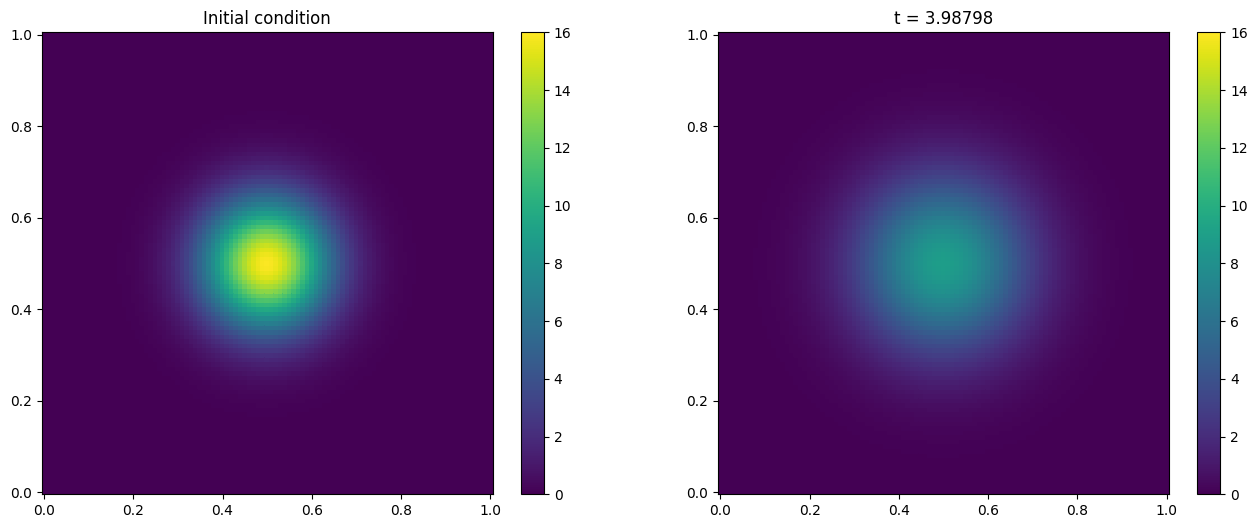

In [16]:
# Plot the numerical results
# (Is it good enough? Did I do it correctly?)
print('Number of t_idx: ', len(t))
fig, ax = plt.subplots(1,2, figsize=(16,6))
color_init = ax[0].pcolor(X, Y, U[0], vmin=0, vmax =16)
ax[0].set_title('Initial condition')
fig.colorbar(color_init)
t_idx = 199
color1 = ax[1].pcolor(X, Y, U[t_idx], vmin=0, vmax=16)
ax[1].set_title(f't = {t[t_idx]:.5f}')
fig.colorbar(color1)

In [17]:
u_TT = np.transpose(U, (1,2,0))
u_T = np.zeros((nx, ny, len(t), 1))
u_T[:, :, :, 0] = u_TT
# (nx, nx, nt)
# Compute u_t from generated solution, using finite differencing
u_dot = ps.FiniteDifference(axis=2)._differentiate(u_T, dt)
X_1 , Y_1 = np.meshgrid(x,y)
spatial_grid = np.asarray([X_1, Y_1]).T

In [18]:
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    diff_kwargs={'is_uniform': True}
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1e-4)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
# can take a few mins
model.fit(u_T, x_dot=u_dot)
print('noiseless fit: ')
model.print()
print('R2 score: ', model.score(u_T, t=t))

STLSQ model: 
noiseless fit: 
(u)' = 0.001 u_22 + 0.001 u_11
R2 score:  0.9999939856152681


What if the data is noisy? We can use *weak* formulation of the equation / data, in order to "integrate out" the noise. Below add some randon noise to the solution and use ``WeakPDELibrary``.

From Pysindy documentation:


> It is often difficult to identify dynamical systems in the presence of substantial noise. Towards that end, a number of publications have used SINDy to identify the weak-formulation (integral formulation) of the system of ODEs or PDEs. This allows one to avoid taking high-order derivatives of noisy data (high-order derivatives of noisy data will amplify the noise).

Asides, the weak form of this diffusion equation should be ($D$ is assumed to constant):

\begin{align}
\int_{\Omega} \frac{\partial u}{\partial t} \phi \, dx &= D \int_{\Omega} \phi \nabla^2 u\, dx\qquad u, \phi \in V\\
&= D \left(\int_{\partial \Omega} \phi \nabla u \cdot \mathbf{n} \, ds  - \int_{\Omega} \nabla \phi \cdot \nabla u \, dx \right)
\end{align}


Number of t_idx:  500


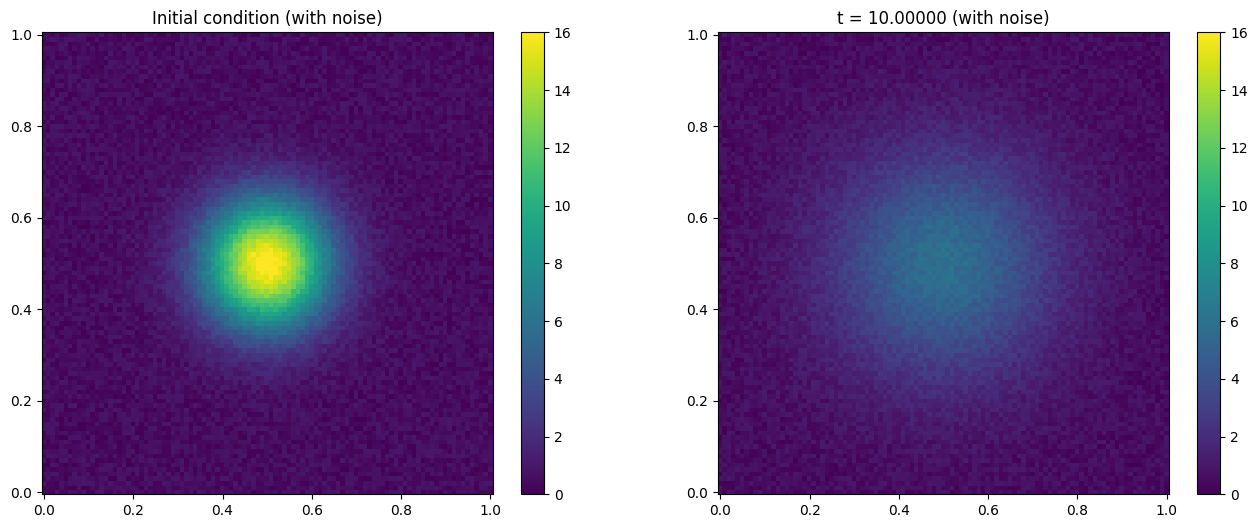

In [19]:
# add random noise to solution
U_noisy = U + np.random.rand(U.shape[0], U.shape[1], U.shape[2])
print('Number of t_idx: ', len(t))
fig, ax = plt.subplots(1,2, figsize=(16,6))
color_init = ax[0].pcolor(X, Y, U_noisy[0], vmin=0, vmax =16)
ax[0].set_title('Initial condition (with noise)')
fig.colorbar(color_init)
t_idx = 499
color1 = ax[1].pcolor(X, Y, U_noisy[t_idx], vmin=0, vmax=16)
ax[1].set_title(f't = {t[t_idx]:.5f} (with noise)')
fig.colorbar(color1)

In [20]:
u_TT = np.transpose(U_noisy, (1,2,0))
u_T = np.zeros((nx, ny, len(t), 1))
u_T[:, :, :, 0] = u_TT

In [21]:
spatialtemporal_grid = np.zeros((nx, ny, len(t), 3))
spatialtemporal_grid[:, :, :, 0] = x[:, np.newaxis, np.newaxis]
spatialtemporal_grid[:, :, :, 1] = y[np.newaxis, :, np.newaxis]
spatialtemporal_grid[:, :, :, 2] = t[np.newaxis, np.newaxis, :]

weak_pde_library = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=3, include_bias=False),
    derivative_order=3,
    spatiotemporal_grid=spatialtemporal_grid,
    K=100,)

# fit the nosiy data
optimizer = ps.STLSQ(threshold=1e-4)
model = ps.SINDy(
    feature_library=weak_pde_library,
    optimizer=optimizer,
    feature_names=['u']
)
# notice I did not pass in u_dot
model.fit(u_T, t=t)
print('Noisy weak fit: ')
model.print()
print('R2 score: ', model.score(u_T, t=t))

Noisy weak fit: 
(u)' = 0.001 u_22 + 0.001 u_11
R2 score:  0.825565909280629


### Limitation of Pysindy

- In real application, data is often noisy and most of the underlying is often unknown to us. It is difficult to find the correct the basis and fit to a solution that converges.

- One could try creating many basis and let the optimisaton decides what to keep. But as seen above, multiple solution might appear, and some random terms can also be incorporated. For example, the solution could have random terms like, $0.0001\sin(100 x) + 10^{-9} \cos(50x)$ and it would not impact the prediction that much.

- These coefficients are just scalar values, but in real world these 'coefficients' rarely scalar. They could be functions of space and time, i.e. tensors. For example, the stiffness tensor in Hooke's law, $c_{ijkl}$.


- This is machine learning, so it naturally inherents problems from machine learning. e.g. hyperparameters require tuning, model over fitting, and computational resource demanding.

Reference:

[1] S.L. Brunton, J.L. Proctor, & J.N. Kutz, Discovering governing equations from data by sparse identification of nonlinear dynamical systems, Proc. Natl. Acad. Sci. U.S.A. 113 (15) 3932-3937, https://doi.org/10.1073/pnas.1517384113 (2016).

[2] Brian M. de Silva, Kathleen Champion, Markus Quade, Jean-Christophe Loiseau, J. Nathan Kutz, and Steven L. Brunton., (2020). PySINDy: A Python package for the sparse identification of nonlinear dynamical systems from data. Journal of Open Source Software, 5(49), 2104, https://doi.org/10.21105/joss.02104

[3] Kaptanoglu et al., (2022). PySINDy: A comprehensive Python package for robust sparse system identification. Journal of Open Source Software, 7(69), 3994, https://doi.org/10.21105/joss.03994